# Transfer Learning in PyTorch

This lecture will walk through the steps for fine-tuning a pre-trained CNN (e.g., AlexNet) in PyTorch. We'll explore:

1. **Loading a pre-trained model**  
2. **Inspecting trainable parameters**  
3. **Adjusting layers: freezing and unfreezing**  
4. **Replacing the output (classification) layer**  
5. **Replacing the entire (classification) head**  


---

**Loading a pre-trained model**

PyTorch makes it easy to load pre-trained models from `torchvision.models`. 

Let's load AlexNet, a CNN that was one of the early deep learning models to perform well on ImageNet.

In [1]:
import torch
import torch.nn as nn
from torchvision import models


In [2]:
# Load AlexNet with pre-trained weights
model = models.alexnet(pretrained=True)

/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The AlexNet architecture consists of convolutional layers (for feature extraction) followed by a fully connected (FC) classification head. 

The FC layer outputs predictions for 1,000 ImageNet classes.

In [3]:
# note that all layers are shown in order below. The first layers are printed first, and the last ones last.

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

---

**Inspecting trainable parameters**

In PyTorch, each layer has an attribute `.requires_grad` that determines whether the parameters of that layer are updated during training.


In [4]:
for name, param in model.named_parameters():
    print(f'Requires grad: {param.requires_grad} | Parameter name: {name}')

Requires grad: True | Parameter name: features.0.weight
Requires grad: True | Parameter name: features.0.bias
Requires grad: True | Parameter name: features.3.weight
Requires grad: True | Parameter name: features.3.bias
Requires grad: True | Parameter name: features.6.weight
Requires grad: True | Parameter name: features.6.bias
Requires grad: True | Parameter name: features.8.weight
Requires grad: True | Parameter name: features.8.bias
Requires grad: True | Parameter name: features.10.weight
Requires grad: True | Parameter name: features.10.bias
Requires grad: True | Parameter name: classifier.1.weight
Requires grad: True | Parameter name: classifier.1.bias
Requires grad: True | Parameter name: classifier.4.weight
Requires grad: True | Parameter name: classifier.4.bias
Requires grad: True | Parameter name: classifier.6.weight
Requires grad: True | Parameter name: classifier.6.bias


Let's create a function to **inspect the trainable parameters** and calculate:
- The total number of parameters.
- The number and percentage of trainable parameters.

In [5]:
def count_parameters(model):

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Percentage Trainable: {100 * trainable_params / total_params:.2f}%")


count_parameters(model)

Total Parameters: 61,100,840
Trainable Parameters: 61,100,840
Percentage Trainable: 100.00%


In [6]:
# own version
import torchinfo
print(str(torchinfo.summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "params_percent", "kernel_size", "trainable",])))
print(f"Percentage Trainable: {100 * sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()):.2f}%")

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Trainable
AlexNet                                  [1, 3, 224, 224]          [1, 1000]                 --                             --                   --                        True
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 256, 6, 6]            --                             --                   --                        True
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 55, 55]           23,296                      0.04%                   [11, 11]                  True
│    └─ReLU: 2-2                         [1, 64, 55, 55]           [1, 64, 55, 55]           --                             --                   --                        --
│    └─MaxPool2d: 2-3                    [1, 64, 55, 55]           [1, 64, 27, 27]           --                      

As seen, all parameters are initially trainable.

---

**Adjusting layers, freezing and unfreezing**

To **freeze a layer**, set its `.requires_grad` attribute to `False`. This prevents the optimizer from updating the layer's weights during training. Freezing is typically applied to lower layers (convolutional layers), which extract generic features, while leaving the classification head trainable.

Let's freeze all layers.

In [7]:
for name, param in model.named_parameters():      # loops over all layers
    param.requires_grad = False                   # freezes the actual layer

# Check trainable parameters again
count_parameters(model)

Total Parameters: 61,100,840
Trainable Parameters: 0
Percentage Trainable: 0.00%


In [8]:
# double check requires grad status of layers

for name, param in model.named_parameters():
    print(f'Requires grad: {param.requires_grad} | Parameter name: {name}')

Requires grad: False | Parameter name: features.0.weight
Requires grad: False | Parameter name: features.0.bias
Requires grad: False | Parameter name: features.3.weight
Requires grad: False | Parameter name: features.3.bias
Requires grad: False | Parameter name: features.6.weight
Requires grad: False | Parameter name: features.6.bias
Requires grad: False | Parameter name: features.8.weight
Requires grad: False | Parameter name: features.8.bias
Requires grad: False | Parameter name: features.10.weight
Requires grad: False | Parameter name: features.10.bias
Requires grad: False | Parameter name: classifier.1.weight
Requires grad: False | Parameter name: classifier.1.bias
Requires grad: False | Parameter name: classifier.4.weight
Requires grad: False | Parameter name: classifier.4.bias
Requires grad: False | Parameter name: classifier.6.weight
Requires grad: False | Parameter name: classifier.6.bias


**Unfreezing Specific Layers**

If your task requires fine-tuning certain layers, you can selectively unfreeze them.

In [9]:
# Unfreeze only the last classifier layer (the output layer) 
for name, param in model.named_parameters():
    if "classifier.6" in name:                
        param.requires_grad = True

# Check trainable parameters again
count_parameters(model)

Total Parameters: 61,100,840
Trainable Parameters: 4,097,000
Percentage Trainable: 6.71%


In [10]:
for name, param in model.named_parameters():
    print(f'Requires grad: {param.requires_grad} | Parameter name: {name}')

Requires grad: False | Parameter name: features.0.weight
Requires grad: False | Parameter name: features.0.bias
Requires grad: False | Parameter name: features.3.weight
Requires grad: False | Parameter name: features.3.bias
Requires grad: False | Parameter name: features.6.weight
Requires grad: False | Parameter name: features.6.bias
Requires grad: False | Parameter name: features.8.weight
Requires grad: False | Parameter name: features.8.bias
Requires grad: False | Parameter name: features.10.weight
Requires grad: False | Parameter name: features.10.bias
Requires grad: False | Parameter name: classifier.1.weight
Requires grad: False | Parameter name: classifier.1.bias
Requires grad: False | Parameter name: classifier.4.weight
Requires grad: False | Parameter name: classifier.4.bias
Requires grad: True | Parameter name: classifier.6.weight
Requires grad: True | Parameter name: classifier.6.bias


---

**Replacing the Classification Layer**

The classification layer of AlexNet is named `model.classifier[6]`, which is a fully connected (FC) layer with 1,000 outputs suitable for ImageNet classes. 

For a new task (e.g., 10-class classification), replace this with a new FC layer.

In [11]:
num_features = model.classifier[6].in_features     # get the number of input features the current classification layer
model.classifier[6] = nn.Linear(num_features, 10)  # replace it with a new classification layer with 10 outputs

# print updated model, check the the last layer output size is now 10 (previous was 1,000)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
# count current trainable parameters
count_parameters(model)

Total Parameters: 57,044,810
Trainable Parameters: 40,970
Percentage Trainable: 0.07%


In [13]:
for name, param in model.named_parameters():
    print(f'Requires grad: {param.requires_grad} | Parameter name: {name}')

Requires grad: False | Parameter name: features.0.weight
Requires grad: False | Parameter name: features.0.bias
Requires grad: False | Parameter name: features.3.weight
Requires grad: False | Parameter name: features.3.bias
Requires grad: False | Parameter name: features.6.weight
Requires grad: False | Parameter name: features.6.bias
Requires grad: False | Parameter name: features.8.weight
Requires grad: False | Parameter name: features.8.bias
Requires grad: False | Parameter name: features.10.weight
Requires grad: False | Parameter name: features.10.bias
Requires grad: False | Parameter name: classifier.1.weight
Requires grad: False | Parameter name: classifier.1.bias
Requires grad: False | Parameter name: classifier.4.weight
Requires grad: False | Parameter name: classifier.4.bias
Requires grad: True | Parameter name: classifier.6.weight
Requires grad: True | Parameter name: classifier.6.bias


We've now replaced the original classification (ouput) layer with a customer layer. This layer is now both unfrozeen and initialized with random parameters.

---

**Replacing the Entire Classification Head**

For more flexibility, you can replace the **entire classification head**, not just the last layer. In AlexNet, the head typically starts after the feature extractor (convolutional layers).

Note also that the the whole classification head is encapsulated in 'model.classifier', using the so-called nn.Sequential syntax. 

We can define our own nn.Sequential head and replace the built-in one with it.


In [14]:
# example of nn.Sequential syntax

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.model = nn.Sequential(
                                    # Layer 1: Conv -> ReLU -> Pool
                                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2), 

                                    # Layer 2: Conv -> ReLU -> Pool
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2), 

                                    # Layer 3: Conv -> ReLU -> Pool
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2), 

                                    # Flatten
                                    nn.Flatten(),

                                    # One-layer classification head
                                    nn.Linear(64 * 4 * 4, num_classes)  # Assuming input size 32x32
                                )

    def forward(self, x):
        return self.model(x)

In [15]:
# the whole classifier encapulated in model.classifier

model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [16]:
# note that the first layer of neurons in the classifier head has 9216 in_features, we need to have the same in our new head.

head_in_features = 9216

In [17]:
# Define a custom sequence and replace the entire classification head with it
# note that our custom sequence architecture is completely arbitrary and up to us to decide
# only constrains are the 9216 in_features and 10 out_features of the last layer (which corresponds to the problem we want to solve)


model.classifier = nn.Sequential(
                                 nn.Linear(head_in_features, 512),  # First FC layer
                                 nn.ReLU(),                         
                                 nn.Dropout(0.5),                   
                                 nn.Linear(512, 10)                 # Output layer
                                )

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, i

In [18]:
# Check parameters again after adding a new head
count_parameters(model)

Total Parameters: 7,193,930
Trainable Parameters: 4,724,234
Percentage Trainable: 65.67%


In [19]:
for name, param in model.named_parameters():
    print(f'Requires grad: {param.requires_grad} | Parameter name: {name}')

Requires grad: False | Parameter name: features.0.weight
Requires grad: False | Parameter name: features.0.bias
Requires grad: False | Parameter name: features.3.weight
Requires grad: False | Parameter name: features.3.bias
Requires grad: False | Parameter name: features.6.weight
Requires grad: False | Parameter name: features.6.bias
Requires grad: False | Parameter name: features.8.weight
Requires grad: False | Parameter name: features.8.bias
Requires grad: False | Parameter name: features.10.weight
Requires grad: False | Parameter name: features.10.bias
Requires grad: True | Parameter name: classifier.0.weight
Requires grad: True | Parameter name: classifier.0.bias
Requires grad: True | Parameter name: classifier.3.weight
Requires grad: True | Parameter name: classifier.3.bias


Maybe we'd like to unfreeze the last conv layer aswell?

In [20]:
# Unfreeze only the last classifier layer (the output layer) 
for name, param in model.named_parameters():
    if "features.10" in name:                
        param.requires_grad = True

# Check trainable parameters again
count_parameters(model)

Total Parameters: 7,193,930
Trainable Parameters: 5,314,314
Percentage Trainable: 73.87%


In [21]:
for name, param in model.named_parameters():
    print(f'Requires grad: {param.requires_grad} | Parameter name: {name}')

Requires grad: False | Parameter name: features.0.weight
Requires grad: False | Parameter name: features.0.bias
Requires grad: False | Parameter name: features.3.weight
Requires grad: False | Parameter name: features.3.bias
Requires grad: False | Parameter name: features.6.weight
Requires grad: False | Parameter name: features.6.bias
Requires grad: False | Parameter name: features.8.weight
Requires grad: False | Parameter name: features.8.bias
Requires grad: True | Parameter name: features.10.weight
Requires grad: True | Parameter name: features.10.bias
Requires grad: True | Parameter name: classifier.0.weight
Requires grad: True | Parameter name: classifier.0.bias
Requires grad: True | Parameter name: classifier.3.weight
Requires grad: True | Parameter name: classifier.3.bias


---

## Next Steps: Training the Model

Using our model for training is super easy. We have it saved in the variable `model` and can, at any point,

throw it into our training loop and train it - usually once we're satisfied with freezing/unfreezing of layers 

and potential replacement of the classification head/layers. 

**Note**: 

For optimal performance, you might need to resize your images to the input size (often 224x224) of the pre-trained model. 

This can easily be done using transformations though. Look it up.

In [55]:
from torchvision import datasets, transforms
import torch

# set up transforms
# transform = transforms.Compose([
#     transforms.Resize(224),         # resize images to 224x224 for alexnet
#     transforms.ToTensor(),          # convert images to tensor format
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1)),                                 # convert grayscale to 3 channels
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # normalize using imagenet stats
# ])

transform = transforms.Compose([
    transforms.Resize(224),                           # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),      # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize as per ImageNet
                         std=[0.229, 0.224, 0.225])
])

# load training and test datasets with transforms
trainset = datasets.FashionMNIST(root='../w4/data/', train=True, download=True, transform=transform)
valset = datasets.FashionMNIST(root='../w4/data/', train=False, download=True, transform=transform)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


#### Show new 224x224 images

tensor shape: torch.Size([3, 224, 224])
value range: [-2.118, 2.623]
label: 9


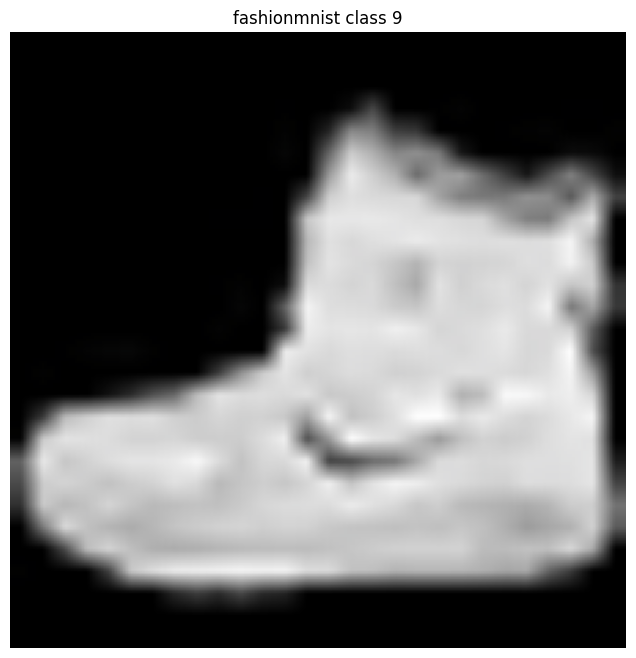

In [24]:
import matplotlib.pyplot as plt
import torchvision

# function to show image and print metadata
def inspect_image(dataset, idx=0):
    img, label = dataset[idx]
    
    # print metadata
    print(f"tensor shape: {img.shape}")
    print(f"value range: [{img.min():.3f}, {img.max():.3f}]")
    print(f"label: {label}")
    
    # denormalize and convert to displayable format
    img_display = img.permute(1, 2, 0).numpy()
    img_display = (img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
    
    # display
    plt.figure(figsize=(8, 8))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f'fashionmnist class {label}')
    plt.show()

# show a grid of images
def show_image_grid(dataset, num_images=16):
    imgs = [dataset[i][0] for i in range(num_images)]
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    
    # denormalize
    grid_display = grid.permute(1, 2, 0).numpy()
    grid_display = (grid_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_display)
    plt.axis('off')
    plt.show()

# inspect single image
inspect_image(trainset, idx=0)

# show grid of images
# show_image_grid(trainset)

In [44]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, in

In [81]:
# create parameter groups with different learning rates
params_to_update = []
params_to_finetune = []

layers_to_finetune = ["features.10"]

# separate parameters into two groups
for name, param in model.named_parameters():
    if any(layer in name for layer in layers_to_finetune):  # fine-tuning group (pretrained layer)
        params_to_finetune.append(param)
        param.requires_grad = True
    elif "classifier" in name:  # feature extraction group (new layers)
        params_to_update.append(param)
        param.requires_grad = True

In [82]:
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

features.0.weight: False
features.0.bias: False
features.3.weight: False
features.3.bias: False
features.6.weight: False
features.6.bias: False
features.8.weight: False
features.8.bias: False
features.10.weight: False
features.10.bias: False
classifier.0.weight: True
classifier.0.bias: True
classifier.3.weight: True
classifier.3.bias: True
classifier.6.weight: True
classifier.6.bias: True


[epoch 01] train loss: 0.7098 | val loss: 0.4461 | accuracy: 84.23%
Validation loss decreased (inf --> 0.4461). Saving model.
[epoch 02] train loss: 0.5345 | val loss: 0.4132 | accuracy: 88.08%
Validation loss decreased (0.4461 --> 0.4132). Saving model.
[epoch 03] train loss: 0.4934 | val loss: 0.3524 | accuracy: 88.12%
Validation loss decreased (0.4132 --> 0.3524). Saving model.
[epoch 04] train loss: 0.4560 | val loss: 0.3792 | accuracy: 88.05%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 0.4371 | val loss: 0.3633 | accuracy: 88.71%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 0.4113 | val loss: 0.3420 | accuracy: 88.67%
Validation loss decreased (0.3524 --> 0.3420). Saving model.
[epoch 07] train loss: 0.3885 | val loss: 0.3256 | accuracy: 89.07%
Validation loss decreased (0.3420 --> 0.3256). Saving model.
[epoch 08] train loss: 0.3684 | val loss: 0.3144 | accuracy: 88.89%
Validation loss decreased (0.3256 --> 0.3144). Saving model.
[epoch 09] train loss: 0.

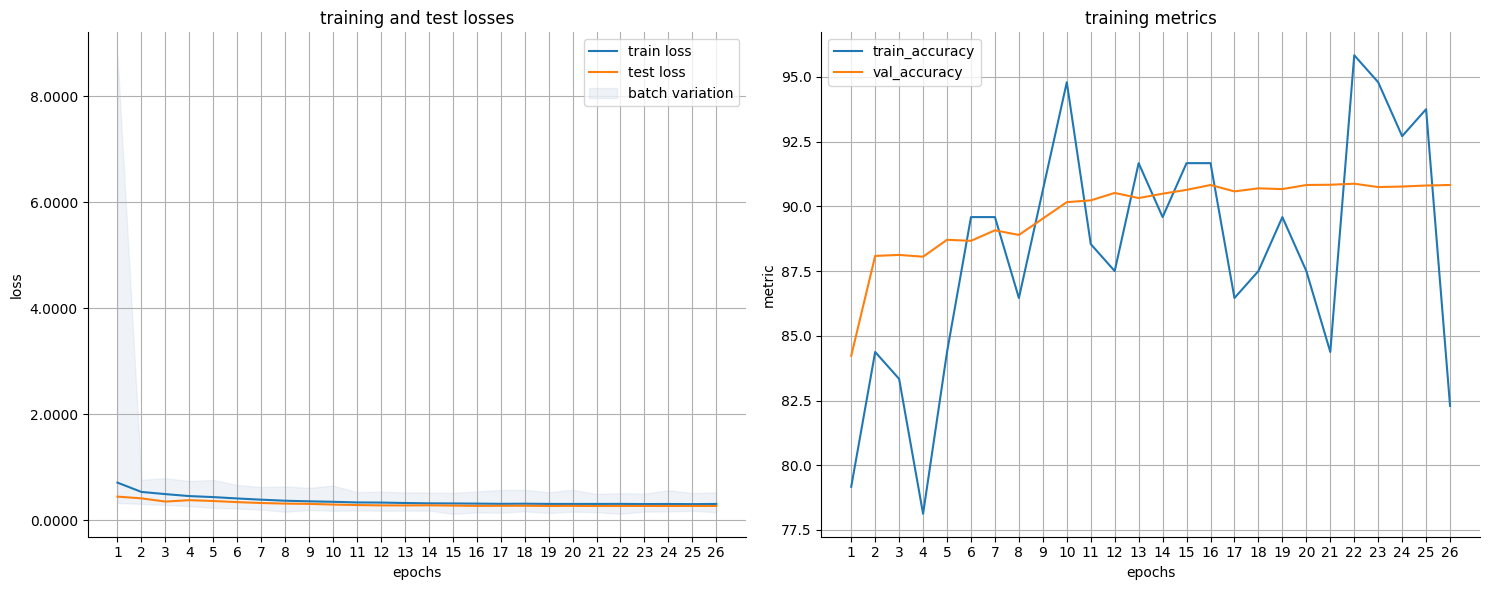

In [83]:
import torch
import torch.nn as nn
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path

# package_root = Path('/home/goose/projects/deeplearning/deep_learning_tools')
package_root = Path('/home/gustaf/projects/deeplearning/deep_learning_tools')
sys.path.append(str(package_root))

from src import ModelTrainer

head_in_features = 9216

model.classifier = nn.Sequential(
                                 nn.Linear(head_in_features, 512),
                                 nn.ReLU(),                         
                                 nn.Dropout(0.5),                   
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 10)
                                )

# create optimizer with parameter groups
optimizer = Adam([
    {'params': params_to_finetune, 'lr': 0.0001},  # lower lr for fine-tuning
    {'params': params_to_update, 'lr': 0.001}      # higher lr for new layers
], weight_decay=0.01)

# optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)


# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,
    save_metrics=True,
    early_stopping_patience=5,
    early_stopping_delta=0.00001
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

In [ ]:
[epoch 01] train loss: 0.3508 | val loss: 0.2442 | accuracy: 91.48%
Validation loss decreased (inf --> 0.2442). Saving model.
[epoch 02] train loss: 0.2635 | val loss: 0.2345 | accuracy: 92.00%
Validation loss decreased (0.2442 --> 0.2345). Saving model.
[epoch 03] train loss: 0.2434 | val loss: 0.2207 | accuracy: 92.38%
Validation loss decreased (0.2345 --> 0.2207). Saving model.
[epoch 04] train loss: 0.2316 | val loss: 0.2210 | accuracy: 92.36%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 0.2221 | val loss: 0.2211 | accuracy: 92.34%
EarlyStopping counter: 2 out of 5
[epoch 06] train loss: 0.2113 | val loss: 0.2135 | accuracy: 92.58%
Validation loss decreased (0.2207 --> 0.2135). Saving model.
[epoch 07] train loss: 0.2077 | val loss: 0.2133 | accuracy: 92.52%
Validation loss decreased (0.2135 --> 0.2133). Saving model.
[epoch 08] train loss: 0.1998 | val loss: 0.2092 | accuracy: 92.74%
Validation loss decreased (0.2133 --> 0.2092). Saving model.
[epoch 09] train loss: 0.1936 | val loss: 0.2075 | accuracy: 92.82%
Validation loss decreased (0.2092 --> 0.2075). Saving model.
[epoch 10] train loss: 0.1901 | val loss: 0.2037 | accuracy: 92.86%
Validation loss decreased (0.2075 --> 0.2037). Saving model.
[epoch 11] train loss: 0.1854 | val loss: 0.2019 | accuracy: 93.04%
Validation loss decreased (0.2037 --> 0.2019). Saving model.
[epoch 12] train loss: 0.1830 | val loss: 0.2038 | accuracy: 92.87%
EarlyStopping counter: 1 out of 5
[epoch 13] train loss: 0.1837 | val loss: 0.2019 | accuracy: 92.83%
Validation loss decreased (0.2019 --> 0.2019). Saving model.
[epoch 14] train loss: 0.1819 | val loss: 0.2015 | accuracy: 92.89%
Validation loss decreased (0.2019 --> 0.2015). Saving model.
[epoch 15] train loss: 0.1797 | val loss: 0.2003 | accuracy: 92.88%
Validation loss decreased (0.2015 --> 0.2003). Saving model.
[epoch 16] train loss: 0.1780 | val loss: 0.2004 | accuracy: 92.97%
EarlyStopping counter: 1 out of 5
[epoch 17] train loss: 0.1766 | val loss: 0.1997 | accuracy: 92.91%
Validation loss decreased (0.2003 --> 0.1997). Saving model.
[epoch 18] train loss: 0.1786 | val loss: 0.1999 | accuracy: 92.96%
EarlyStopping counter: 1 out of 5
[epoch 19] train loss: 0.1769 | val loss: 0.2002 | accuracy: 92.89%
EarlyStopping counter: 2 out of 5
[epoch 20] train loss: 0.1763 | val loss: 0.1999 | accuracy: 92.92%
EarlyStopping counter: 3 out of 5
[epoch 21] train loss: 0.1747 | val loss: 0.2000 | accuracy: 92.96%
EarlyStopping counter: 4 out of 5
[epoch 22] train loss: 0.1776 | val loss: 0.1997 | accuracy: 93.01%
Validation loss decreased (0.1997 --> 0.1997). Saving model.
[epoch 23] train loss: 0.1732 | val loss: 0.1997 | accuracy: 93.03%
EarlyStopping counter: 1 out of 5
[epoch 24] train loss: 0.1749 | val loss: 0.1998 | accuracy: 93.00%
EarlyStopping counter: 2 out of 5
[epoch 25] train loss: 0.1761 | val loss: 0.1996 | accuracy: 92.99%
Validation loss decreased (0.1997 --> 0.1996). Saving model.
[epoch 26] train loss: 0.1738 | val loss: 0.1996 | accuracy: 93.02%
Validation loss decreased (0.1996 --> 0.1996). Saving model.
[epoch 27] train loss: 0.1729 | val loss: 0.1996 | accuracy: 92.98%
EarlyStopping counter: 1 out of 5
[epoch 28] train loss: 0.1740 | val loss: 0.1996 | accuracy: 92.98%
EarlyStopping counter: 2 out of 5
[epoch 29] train loss: 0.1752 | val loss: 0.1997 | accuracy: 93.00%
EarlyStopping counter: 3 out of 5
[epoch 30] train loss: 0.1742 | val loss: 0.1997 | accuracy: 93.01%
EarlyStopping counter: 4 out of 5
[epoch 31] train loss: 0.1760 | val loss: 0.1997 | accuracy: 93.01%
EarlyStopping counter: 5 out of 5
🚨 Early stopping triggered.

[epoch 01] train loss: 0.2632 | val loss: 0.2390 | accuracy: 91.41%
Validation loss decreased (inf --> 0.2390). Saving model.
[epoch 02] train loss: 0.2084 | val loss: 0.2319 | accuracy: 91.65%
Validation loss decreased (0.2390 --> 0.2319). Saving model.
[epoch 03] train loss: 0.1909 | val loss: 0.2130 | accuracy: 92.63%
Validation loss decreased (0.2319 --> 0.2130). Saving model.
[epoch 04] train loss: 0.1810 | val loss: 0.2215 | accuracy: 92.27%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 0.1717 | val loss: 0.2110 | accuracy: 92.79%
Validation loss decreased (0.2130 --> 0.2110). Saving model.
[epoch 06] train loss: 0.1628 | val loss: 0.2065 | accuracy: 92.71%
Validation loss decreased (0.2110 --> 0.2065). Saving model.
[epoch 07] train loss: 0.1560 | val loss: 0.2079 | accuracy: 92.67%
EarlyStopping counter: 1 out of 5
[epoch 08] train loss: 0.1481 | val loss: 0.2014 | accuracy: 92.80%
Validation loss decreased (0.2065 --> 0.2014). Saving model.
[epoch 09] train loss: 0.

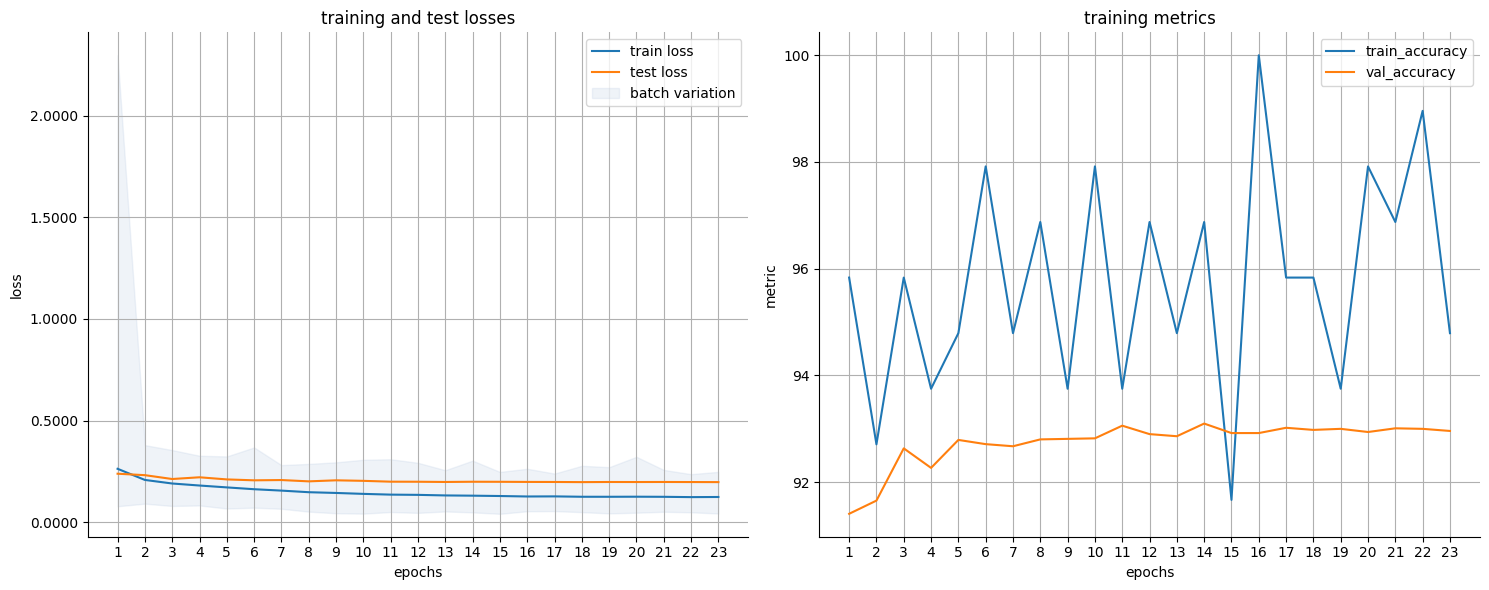

In [51]:
import torch
import torch.nn as nn
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path

# package_root = Path('/home/goose/projects/deeplearning/deep_learning_tools')
package_root = Path('/home/gustaf/projects/deeplearning/deep_learning_tools')
sys.path.append(str(package_root))

from src import ModelTrainer

head_in_features = 9216

model.classifier = nn.Sequential(
                                 nn.Linear(head_in_features, 512),
                                 nn.ReLU(),                         
                                 nn.Dropout(0.5),                   
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 10)
                                )

# create parameter groups with different learning rates
params_to_update = []
params_to_finetune = []

# separate parameters into two groups
for name, param in model.named_parameters():
    if "features.10" in name:  # fine-tuning group (pretrained layer)
        params_to_finetune.append(param)
    elif "classifier" in name:  # feature extraction group (new layers)
        params_to_update.append(param)

# create optimizer with parameter groups
optimizer = Adam([
    {'params': params_to_finetune, 'lr': 0.0001},  # lower lr for fine-tuning
    {'params': params_to_update, 'lr': 0.001}      # higher lr for new layers
], weight_decay=0.01)


# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,
    save_metrics=True,
    early_stopping_patience=5,
    early_stopping_delta=0.00001
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

[epoch 01] train loss: 0.2361 | val loss: 0.2276 | accuracy: 92.19%
Validation loss decreased (inf --> 0.2276). Saving model.
[epoch 02] train loss: 0.1843 | val loss: 0.2678 | accuracy: 90.62%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 0.1706 | val loss: 0.2313 | accuracy: 91.82%
EarlyStopping counter: 2 out of 5
[epoch 04] train loss: 0.1587 | val loss: 0.2257 | accuracy: 92.21%
Validation loss decreased (0.2276 --> 0.2257). Saving model.
[epoch 05] train loss: 0.1484 | val loss: 0.2113 | accuracy: 92.73%
Validation loss decreased (0.2257 --> 0.2113). Saving model.
[epoch 06] train loss: 0.1388 | val loss: 0.2098 | accuracy: 92.78%
Validation loss decreased (0.2113 --> 0.2098). Saving model.
[epoch 07] train loss: 0.1325 | val loss: 0.2047 | accuracy: 92.56%
Validation loss decreased (0.2098 --> 0.2047). Saving model.
[epoch 08] train loss: 0.1258 | val loss: 0.2130 | accuracy: 92.56%
EarlyStopping counter: 1 out of 5
[epoch 09] train loss: 0.1206 | val loss: 0.2063 | a

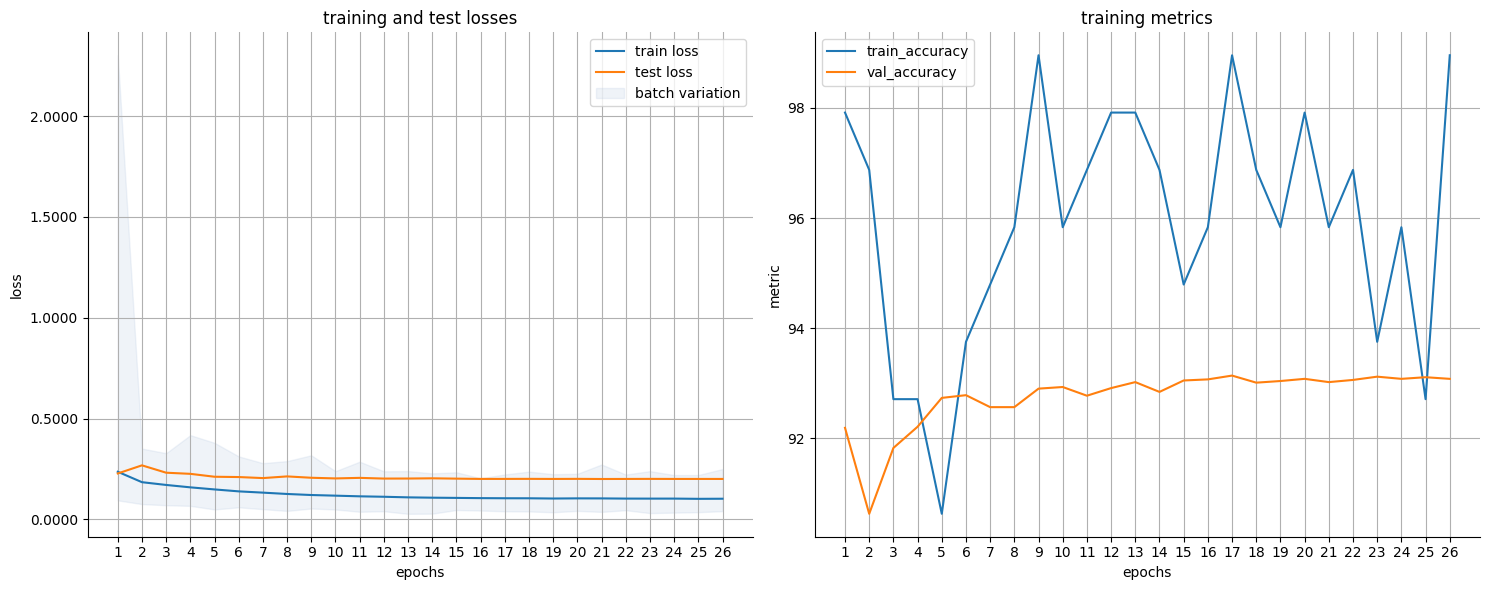

In [52]:
import torch
import torch.nn as nn
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path

# package_root = Path('/home/goose/projects/deeplearning/deep_learning_tools')
package_root = Path('/home/gustaf/projects/deeplearning/deep_learning_tools')
sys.path.append(str(package_root))

from src import ModelTrainer

head_in_features = 9216

model.classifier = nn.Sequential(
                                 nn.Linear(head_in_features, 512),
                                 nn.ReLU(),                         
                                 nn.Dropout(0.5),                   
                                 nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(512, 10)
                                )

# create parameter groups with different learning rates
params_to_update = []
params_to_finetune = []

# separate parameters into two groups
for name, param in model.named_parameters():
    if "features.10" in name:  # fine-tuning group (pretrained layer)
        params_to_finetune.append(param)
    elif "classifier" in name:  # feature extraction group (new layers)
        params_to_update.append(param)

# create optimizer with parameter groups
optimizer = Adam([
    {'params': params_to_finetune, 'lr': 0.0001},  # lower lr for fine-tuning
    {'params': params_to_update, 'lr': 0.001}      # higher lr for new layers
], weight_decay=0.01)


# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,
    save_metrics=True,
    early_stopping_patience=5,
    early_stopping_delta=0.00001
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

[epoch 01] train loss: 0.5670 | val loss: 0.5106 | accuracy: 81.27%
Validation loss decreased (inf --> 0.5106). Saving model.
[epoch 02] train loss: 0.4564 | val loss: 0.4090 | accuracy: 85.37%
Validation loss decreased (0.5106 --> 0.4090). Saving model.
[epoch 03] train loss: 0.4331 | val loss: 0.4072 | accuracy: 86.61%
Validation loss decreased (0.4090 --> 0.4072). Saving model.
[epoch 04] train loss: 0.4129 | val loss: 0.3653 | accuracy: 87.83%
Validation loss decreased (0.4072 --> 0.3653). Saving model.
[epoch 05] train loss: 0.4037 | val loss: 0.3490 | accuracy: 88.14%
Validation loss decreased (0.3653 --> 0.3490). Saving model.
[epoch 06] train loss: 0.3938 | val loss: 0.3469 | accuracy: 88.73%
Validation loss decreased (0.3490 --> 0.3469). Saving model.
[epoch 07] train loss: 0.3847 | val loss: 0.3464 | accuracy: 88.51%
Validation loss decreased (0.3469 --> 0.3464). Saving model.
[epoch 08] train loss: 0.3754 | val loss: 0.3431 | accuracy: 88.92%
Validation loss decreased (0.346

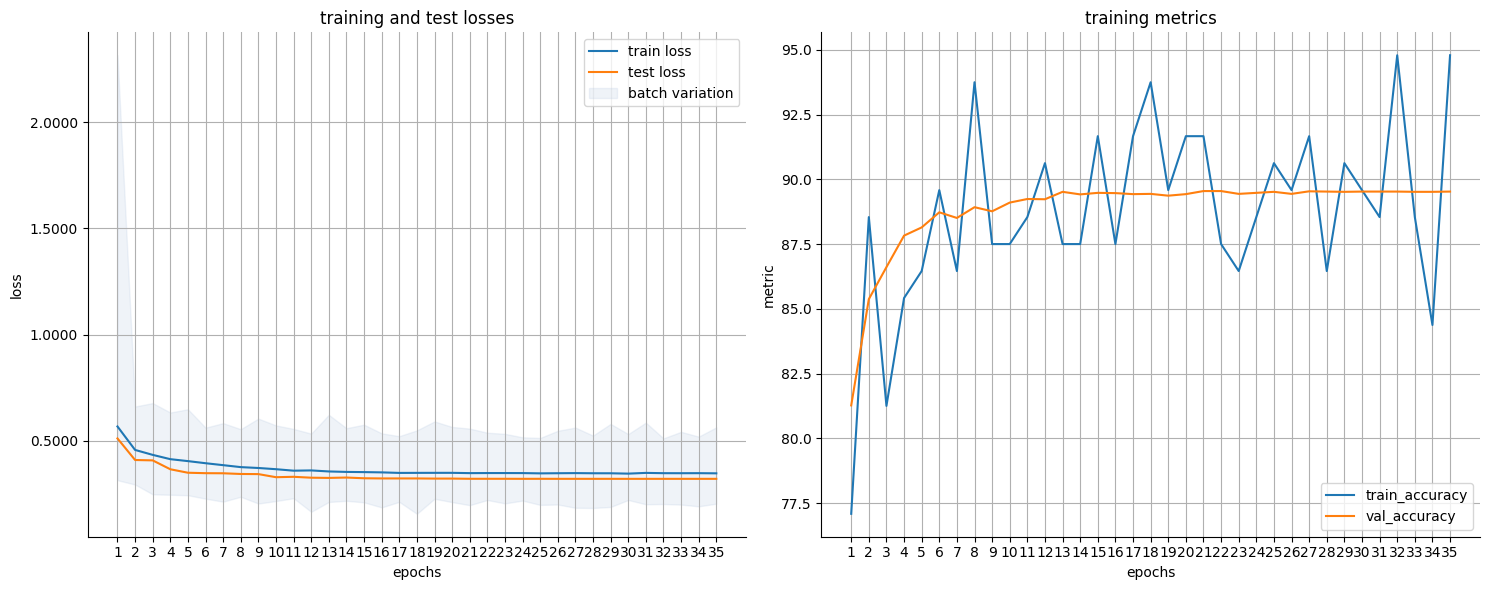

In [53]:
import torch
import torch.nn as nn
from torch.optim import Adadelta, Adam, SGD
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path

# package_root = Path('/home/goose/projects/deeplearning/deep_learning_tools')
package_root = Path('/home/gustaf/projects/deeplearning/deep_learning_tools')
sys.path.append(str(package_root))

from src import ModelTrainer

head_in_features = 9216

model.classifier = nn.Sequential(
                                 nn.Linear(head_in_features, 512),
                                 nn.ReLU(),                         
                                 nn.Dropout(0.5),                   
                                 nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 10)

                                )

# create parameter groups with different learning rates
params_to_update = []
params_to_finetune = []

# separate parameters into two groups
for name, param in model.named_parameters():
    if "features.10" in name:  # fine-tuning group (pretrained layer)
        params_to_finetune.append(param)
    elif "classifier" in name:  # feature extraction group (new layers)
        params_to_update.append(param)

# create optimizer with parameter groups
optimizer = Adam([
    {'params': params_to_finetune, 'lr': 0.001},  # lower lr for fine-tuning
    {'params': params_to_update, 'lr': 0.001}      # higher lr for new layers
], weight_decay=0.05)


# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,
    save_metrics=True,
    early_stopping_patience=5,
    early_stopping_delta=0.00001
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

## Understanding CNN repetition

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, i

**Parameters per convolutional layer**

out_channels * (in_channels * kernel_width * kernel_height + 1) 

**Parameters per fully connected layer**

out_channels * (in_channels + 1)

In [ ]:
in_channels = 3
out_channels = 64
kernel_width = 11
kernel_height = 11
conv2d_0 = out_channels * (in_channels * kernel_width * kernel_height + 1)
conv2d_0

23296

In [ ]:
print(str(torchinfo.summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "params_percent", "kernel_size", "trainable",])))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Trainable
AlexNet                                  [1, 3, 224, 224]          [1, 10]                   --                             --                   --                        Partial
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 256, 6, 6]            --                             --                   --                        Partial
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 55, 55]           (23,296)                    0.32%                   [11, 11]                  False
│    └─ReLU: 2-2                         [1, 64, 55, 55]           [1, 64, 55, 55]           --                             --                   --                        --
│    └─MaxPool2d: 2-3                    [1, 64, 55, 55]           [1, 64, 27, 27]           --               